## Multinomial Classification
### Model Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn2pmml import sklearn2pmml
from sklearn2pmml import ColumnTransformer
from sklearn2pmml.pipeline import PMMLPipeline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [3]:
# Data Import
df = pd.read_csv('../../../data/dry_bean_clean.csv')
# Get features and target
x = df.drop('target', axis=1)
y = df[['target']]

## Data Transformation

In [4]:
# Selecting categorical and numeric features
sel_numeric = make_column_selector(dtype_include=np.number)
x_numerical = sel_numeric(x)

sel_categorical = make_column_selector(dtype_exclude=np.number)
x_categorical = sel_categorical(x)

In [5]:
# Create preprocessing pipelines for numerical features
trans_numerical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
)

In [6]:
# Create preprocessing pipelines for categorical features
trans_categorical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder()),
    ('scaler', StandardScaler())]
)

In [7]:
# Putting the preprocessing steps together
transformer = ColumnTransformer([
    # ('categorical', trans_categorical, x_categorical),
    ('numerical', trans_numerical, x_numerical)],
remainder='passthrough'
)

## Model Training

In [8]:
# Data Split
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.2)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [9]:
list(x_train.columns)

['Area',
 'Perimeter',
 'MajorAxisLength',
 'MinorAxisLength',
 'AspectRation',
 'Eccentricity',
 'ConvexArea',
 'EquivDiameter',
 'Extent',
 'Solidity',
 'roundness',
 'Compactness',
 'ShapeFactor1',
 'ShapeFactor2',
 'ShapeFactor3',
 'ShapeFactor4']

## Multinomial Logistic Regression Model

In [10]:
# Create pipeline with logistic regression as classifier
mnlr_pipeline = PMMLPipeline(steps=[
    ('transformer', transformer),
    ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000))
])

mnlr_pipeline.fit(x_train, y_train)
mnlr_pipeline.verify(x_train.sample(n = 10))

In [11]:
y_pred = mnlr_pipeline.predict(x_test)
y_pred.view()

array(['SEKER', 'BOMBAY', 'HOROZ', ..., 'BARBUNYA', 'CALI', 'CALI'],
      dtype=object)

## Multinomial Logistic Regression - Model Performance

In [12]:
print(f'The model accuracy is: {np.round(accuracy_score(y_test, y_pred), decimals=3)*100}%')
print(f'The model f1 score is: {np.round(f1_score(y_test, y_pred, average="""weighted"""), decimals=3)*100}%')

The model accuracy is: 98.0%
The model f1 score is: 98.0%


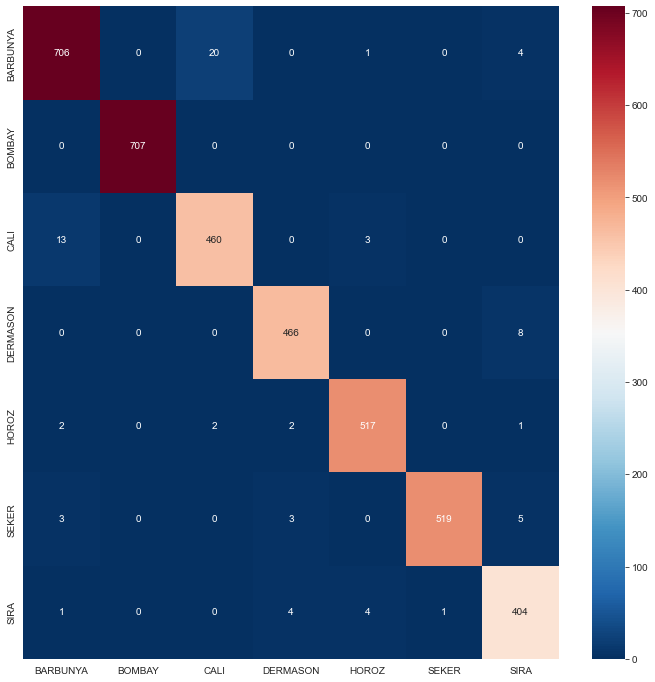

In [13]:
cm = confusion_matrix(y_test, y_pred, labels=mnlr_pipeline.classes_)
plt.figure(figsize=(12, 12))
cmap = sns.color_palette("Oranges",12)
sns.heatmap(data=cm, cmap="RdBu_r", xticklabels=mnlr_pipeline.classes_, yticklabels=mnlr_pipeline.classes_, fmt='g', annot=True)
plt.show()

As we can observer, the diagonal value is the highest value for each row which means we have a good classifier.

## Model Selection

As shown from the models performance,  Multinomial Logistic Regression is the best model

## Save the mode

In [14]:
# Save the best model in PMML format
sklearn2pmml(mnlr_pipeline, "../../../data/MultinomialClassification-LogisticRegression.pmml")